In [39]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold

In [2]:
# prepare data, same as in homework week 3
df = pd.read_csv('../data/cars.csv')
cols = ['Make','Model','Year','Engine HP', 'Engine Cylinders',\
    'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']
df = df[cols]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.engine_cylinders = df.engine_cylinders.fillna(0)
df.engine_hp = df.engine_hp.fillna(0)
df['above_average'] = np.where(df.msrp > df.msrp.mean(), 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11914 non-null  float64
 4   engine_cylinders   11914 non-null  float64
 5   transmission_type  11914 non-null  object 
 6   vehicle_style      11914 non-null  object 
 7   highway_mpg        11914 non-null  int64  
 8   city_mpg           11914 non-null  int64  
 9   msrp               11914 non-null  int64  
 10  above_average      11914 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1024.0+ KB


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [4]:
train_full, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(train_full, test_size=0.25, random_state=1)

y_train = train.above_average.values
y_val = val.above_average.values
y_test = test.above_average.values

In [10]:
train.shape[0], val.shape[0], test.shape[0]

(7148, 2383, 2383)

In [11]:
roc_auc_score(train.above_average, train.engine_hp)

0.9171031265539011

In [12]:
roc_auc_score(train.above_average, train.engine_cylinders)

0.766116490165669

In [13]:
roc_auc_score(train.above_average, -train.highway_mpg)

0.6330587871772013

In [14]:
roc_auc_score(train.above_average, -train.city_mpg)

0.6734244643245233

`engine_hp` has the highest `roc_auc_score`

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [16]:
cols = ['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']
dict_train = train[cols].to_dict(orient='records')
dict_val = val[cols].to_dict(orient='records')
dict_test = test[cols].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]

In [17]:
roc_auc_score(y_val, y_pred).round(3)

0.977

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

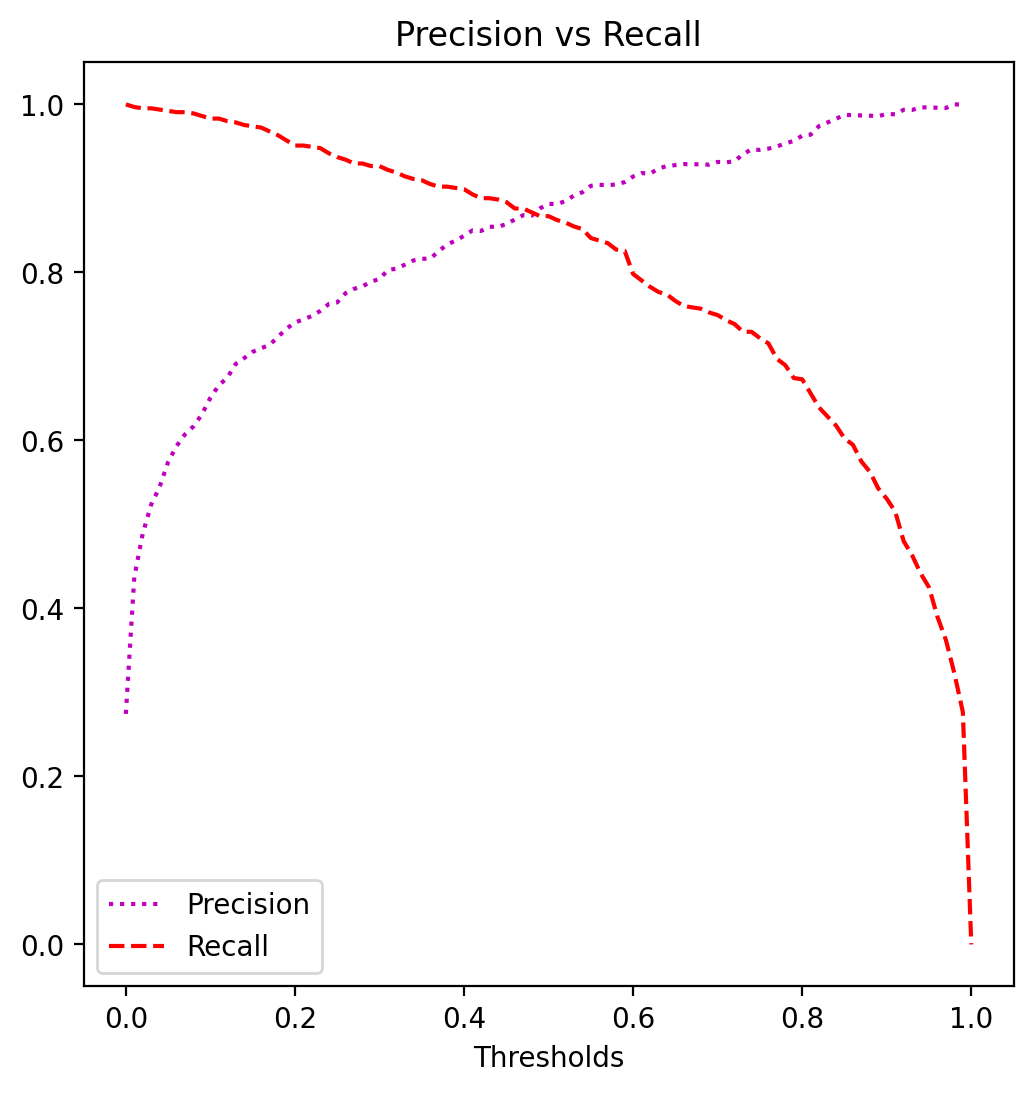

In [28]:
thresholds = np.linspace(0, 1, 101)
scores = []

for t in thresholds:
    # true positive
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    # true negative
    tn = ((y_pred < t) & (y_val == 0)).sum()
    # false positive
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    # false negative
    fn = ((y_pred < t) & (y_val == 1)).sum()

    scores.append((t, tp, tn, fp, fn))

metrics = pd.DataFrame(scores, columns=['threshold', 'tp', 'tn', 'fp', 'fn'])
metrics['precision'] = metrics.tp / (metrics.tp + metrics.fp)
metrics['recall'] = metrics.tp / (metrics.tp + metrics.fn)

plt.figure(figsize=(6, 6))
plt.plot(metrics.threshold, metrics.precision, label='Precision', color='m', linestyle=':')
plt.plot(metrics.threshold, metrics.recall, label='Recall', color='r', linestyle='--')
plt.legend()
plt.xlabel('Thresholds')
plt.title('Precision vs Recall')
plt.show()


Intersect - 0.48

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [35]:
metrics['f1'] = 2* metrics.precision * metrics.recall / (metrics.precision + metrics.recall)
f1max = metrics.f1.max()
metrics.query('f1 == @f1max')

,threshold,tp,tn,fp,fn,precision,recall,f1
50,0.5,567,1653,76,87,0.881804,0.866972,0.874325


In [38]:
metrics.query('threshold == 0.52')

,threshold,tp,tn,fp,fn,precision,recall,f1
52,0.52,562,1656,73,92,0.885039,0.859327,0.871994


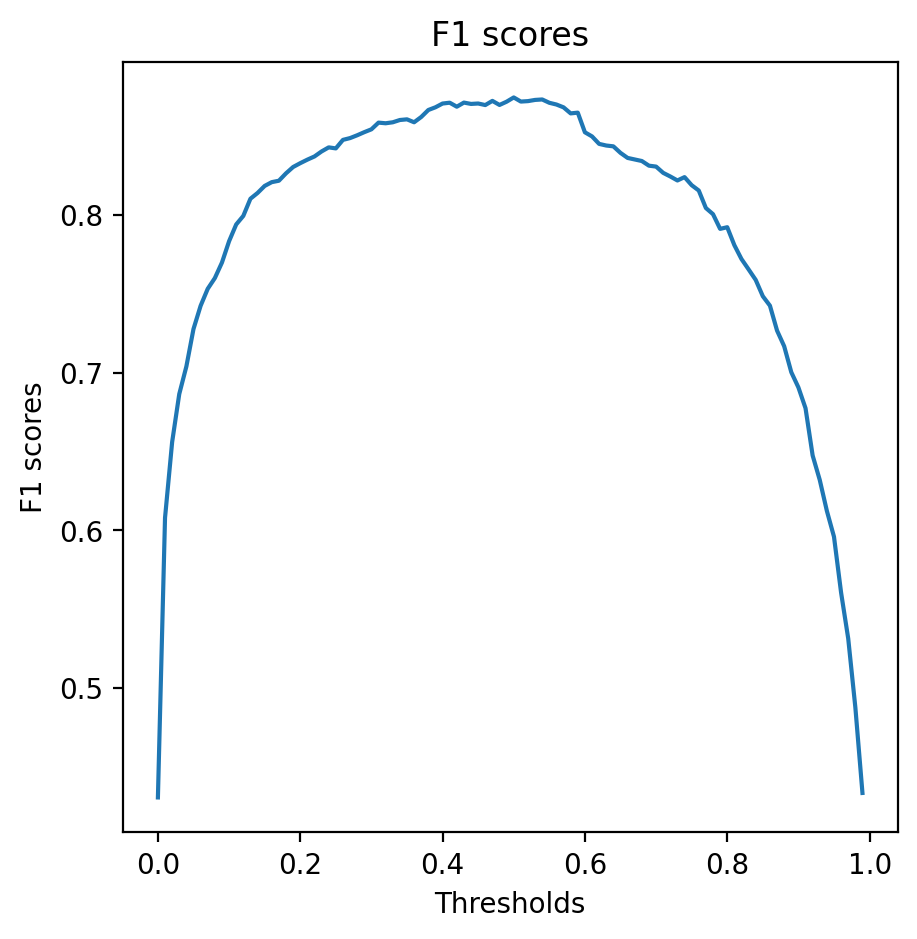

In [52]:
plt.figure(figsize=(5, 5))
plt.plot(metrics.threshold, metrics.f1)
plt.title('F1 scores')
plt.xlabel('Thresholds')
plt.ylabel('F1 scores')
plt.show()

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [40]:
cols

['make',
 'model',
 'year',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']

In [41]:
def train_model(train, y, columns=cols, C=1):
    d = train[columns].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(d)

    X = dv.transform(d)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [43]:
def predict(df, dv, model):
    d = df.to_dict(orient='records')
    
    X = dv.transform(d)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [46]:
y_train_full = train_full.above_average.values

In [48]:
auc_scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(train_full):
    Xt = train_full.iloc[train_idx]
    Xv = train_full.iloc[val_idx]
    yt = y_train_full[train_idx]
    yv = y_train_full[val_idx]
    dv, model = train_model(Xt, yt)
    y_hat = predict(Xv, dv, model)

    auc_scores.append(roc_auc_score(yv, y_hat))
auc_scores

[0.9784891235596622,
 0.9802015987157497,
 0.977745245663934,
 0.9772628408900788,
 0.9776806526806527]

In [49]:
print('%s %.3f %s %.3f' % ('Mean', np.mean(auc_scores), 'STD', np.std(auc_scores)))

Mean 0.978 STD 0.001


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [50]:
for C in [0.01, 0.1, 0.5, 10]:
    auc_scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(train_full):
        Xt = train_full.iloc[train_idx]
        Xv = train_full.iloc[val_idx]
        yt = y_train_full[train_idx]
        yv = y_train_full[val_idx]
        dv, model = train_model(Xt, yt, C=C)
        y_hat = predict(Xv, dv, model)

        auc_scores.append(roc_auc_score(yv, y_hat))
    print('%s %s %s %.3f %s %.3f' % \
        ('C =', C, 'Mean', np.mean(auc_scores), 'STD', np.std(auc_scores)))

C = 0.01 Mean 0.952 STD 0.003
C = 0.1 Mean 0.972 STD 0.002
C = 0.5 Mean 0.977 STD 0.001
C = 10 Mean 0.980 STD 0.003
